# 配列の標準化(normalization)
## Agenda

- normalizationのnumpyでの実装
- PCA実装

### Hardware

In [1]:
%%bash
system_profiler SPHardwareDataType | grep -E \
"Model Identifier"\|"Processor Name"\|"Processor Speed"\
\|"Number of Processors"\|"Memory:"

      Model Identifier: MacBookPro13,1
      Processor Name: Dual-Core Intel Core i5
      Processor Speed: 2 GHz
      Number of Processors: 1
      Memory: 16 GB


In [2]:
!sw_vers

ProductName:	Mac OS X
ProductVersion:	10.15.4
BuildVersion:	19E287


### Python

In [3]:
!python -V

Python 3.7.4


### Import

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from scipy.sparse.linalg import svds
import sklearn
import sklearn.decomposition as dec
import sklearn.datasets as ds

## 1. z-score

$$
x_{i, zscore} = \frac{x_i - \mu}{\sigma}
$$

- $\mu$: mean
- $\sigma$: standard deviation

In [5]:
a = np.array([ 0.7972,  0.0767,  0.4383,  0.7866,  0.8091,
                0.1954,  0.6307,  0.6599,  0.1065,  0.0508])

In [6]:
def zscore(x, axis = None, ddof = 1):
    xmean = x.mean(axis = axis, keepdims = True)
    xstd = x.std(axis = axis, keepdims = True, ddof = ddof)
    zscore = (x - xmean)/xstd
    return zscore

In [7]:
z = zscore(a)

In [8]:
z_scipy = stats.zscore(a, ddof=1)

In [9]:
np.all(z == z_scipy)

True

### 2D array

In [10]:
## N × K arrayの標準化
a = np.random.randint(10, size = (5, 2))
b = zscore(a, axis = 0)
b

array([[-0.61357199,  1.43427433],
       [-0.61357199,  0.23904572],
       [ 0.153393  ,  0.23904572],
       [-0.61357199, -0.95618289],
       [ 1.68732298, -0.95618289]])

## 2. min-max normalization

$$
x_{i, min-max} = \frac{x_i - x_{min}}{x_{max} - x_{min}}
$$

- 想定される分布は一様分布

In [11]:
def min_max(x, axis = None):
    _min = x.min(axis = axis)
    _max = x.max(axis = axis)
    res = (x - _min)/(_max - _min)
    return res

In [12]:
min_max(a, axis  = 0)

array([[0.        , 1.        ],
       [0.        , 0.5       ],
       [0.33333333, 0.5       ],
       [0.        , 0.        ],
       [1.        , 0.        ]])

## 3. Norm標準化

- vector, matrixのnormの標準化(`norm == 1`)

In [13]:
def norm_normalize(x, axis  = 1, order = 2):
    l_norm = np.linalg.norm(x, ord = order, axis  = axis, keepdims = True)
    l_norm[l_norm == 0.0] = 1
    return x/l_norm

In [14]:
b = norm_normalize(a)
b

array([[0.27472113, 0.96152395],
       [0.31622777, 0.9486833 ],
       [0.5547002 , 0.83205029],
       [0.37139068, 0.92847669],
       [0.8479983 , 0.52999894]])

In [15]:
np.sum(b*b, axis = 1)

array([1., 1., 1., 1., 1.])

## 4. なぜscalingが重要なのか？: Principal component analysis

- SVM, K-nearest neighbors, PCA, and logistic regressionといったalgorithmは正規化が必要とされている
- PCAを例とすると、PCAはvarianceを最大化するcomponentの計算が求められるがスケールに応じてvarianceの評価が異なってしまう可能性があるので、事前にre-scalingが必要とされる

### PCAとは？

- dimensionality reductionの手法
- p-dimensional vectorsを q-dimensional subspaceへ写すことを考えるとき、varianceを最大化するprojectionを見つける手法といえる
- 低次元の空間に射影し、射影後の点の散らばりができるだけ大きくなるようにする

### 活用場面
- 多変量データを少ない変数に要約したいとき
- 次元削減
- unsupervised learningの一種としても扱われる

### PCAの作業工程

1. データの標準化:中心化，分散の基準化
2. 分散共分散行列の計算
3. 分散共分散行列を固有値固有ベクトル分解
4. 固有値の大きい方からいくつかの固有値固有ベクトルを取ってくる(= 主成分)
5. 主成分にデータを射影して視覚化および回帰などの処理を続行


### バラツキ(分散)が最大の方向の計算

ある方向ベクトルを$v(||v|| = 1)$とおく。この方向への$x$の長さは、内積$v^Tx$で求まる。よって、$v^Tx_i$の分散は

$$
\frac{1}{n-1}\sum_{i=1}^N[v^T(x_i - \mu)]^2 = v^T\left(\frac{1}{n-1}\sum (x_i - \mu)(x_i - \mu)^T\right)v = v^T\Sigma v
$$

となる。PCAこれを最大化するvを求めること、つまり

$$
\max_{v:||v||=1}v^T\Sigma v
$$

つまり、最大固有値に対応する固有ベクトルを求めることになる。

<img src = "https://github.com/RyoNakagami/omorikaizuka/blob/master/algorithm/固有値.jpg?raw=true">

### 最大固有値とPCA

$$
\begin{aligned}
\max_{v:||v||=1}v^T\Sigma v & = \max_{v:||v||=1}v^TV\Lambda V v\\
&=\max_{v:||v||=1}v^T\Lambda  v \  \ (\because ||Vv|| = 1 \Longleftrightarrow ||v|| = 1)\\
&=\max_{v:||v||=1}\sum_{j=1}^dv_j^2\lambda_j\\
&=\lambda_1
\end{aligned}
$$

- 以下同様に第 j 主成分は j 番目の固有ベクトル $v_j$ である.

### Iris datasetとPCA

In [16]:
iris  = ds.load_iris()

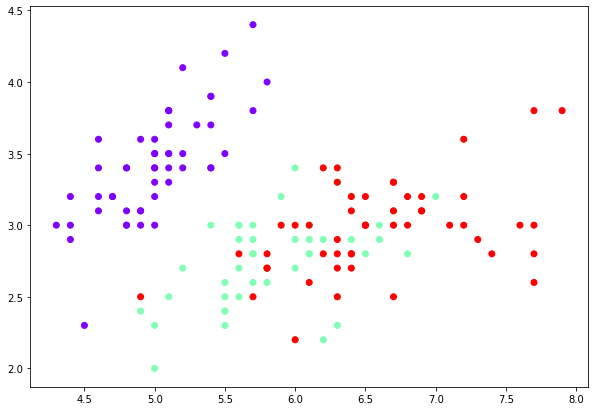

In [17]:
fig, ax  = plt.subplots(1, 1, figsize = (10, 7))
X = iris.data
y = iris.target
ax.scatter(X[:, 0], X[:, 1], c = y, cmap = plt.cm.rainbow);

In [18]:
### 正規化
X = zscore(X)

In [19]:
### covariance matrix
cov_matrix = np.cov(X, rowvar=0, bias= False)

In [20]:
### 固有値と固有ベクトルの計算
w, v = np.linalg.eig(cov_matrix)
ind = np.argsort(w)[::-1]
w, v = w[ind], v[:,ind]

In [21]:
### 寄与率の計算
w/np.sum(w)

array([0.92461872, 0.05306648, 0.01710261, 0.00521218])

In [22]:
#主成分スコアの計算
X_pca = X @ v

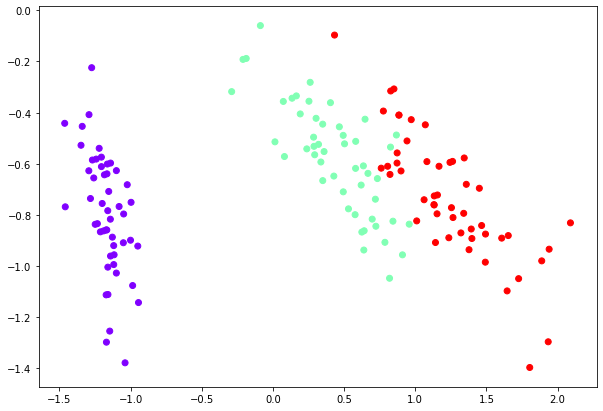

In [23]:
fig, ax  = plt.subplots(1, 1, figsize = (10, 7))
ax.scatter(X_pca[:, 0], X_pca[:, 1], c = y, cmap = plt.cm.rainbow);

## 5. PCA in detail

- $w_1$: 射影する先のベクトル、$||w_1||=1$
- $\{x_i\}^n_{i=1}$: data

$(w_1\cdot x_i)w_1$は$x_i$を$w_1$に射影したときのベクトルとなる。

PCAは$\{w_1\cdot x_i)\}^n_{i=1}$の分散を最大化することで求められるので

$$
\begin{aligned}
\frac{1}{n}\sum ||w_1^Tx_i - w_1^T\bar x||^2 & = \frac{1}{n}\sum \{w_1^T(x_i - \bar x)\}\{(x_i - \bar x)^Tw_1\}\\
& = w_1\left[\frac{1}{n}\sum(x_i - \bar x)(x_i - \bar x)^T\right]w_1\\
& = w_1Sw_1\\
\end{aligned}
$$

つまり、これを変形すると

$$
\max_{w_1} w_1Sw_1 \text{ subject to } w_1^Tw_1 = 1
$$

ラグランジュ乗数法を用いると、

$$
\frac{\partial L}{\partial w_1} = 2Sw_1 - 2\lambda_1w_1 = 0
$$

つまり、
$$
Sw_1 = \lambda_1 w_1
$$

目的関数を最大化するためには$\lambda_1$も最大化されなくてはならないので、PCAはSの最大固有値の固有ベクトルを求めることに相当することがわかる。


### 実装方針
1. covariance matrix Sを計算する
2. Sを特異値分解し、$S = U\Sigma V$とし、Vの上からc行取り出したものを$V^c$とする
3. 与えられたベクトル$x$(data)に対して$V^cx$を計算する

In [24]:
class PCA:
    def __init__(self,n_components=2, tol = 0.0, random_seed = 42):
        self.n_components = n_components ## the number of singular value
        self.tol = tol
        self.random_seed = np.random.RandomState(random_seed)
    
    def fit(self, X):
        v0 = self.random_seed.randn(min(X.shape)) ## initial value
        S = np.cov(X, rowvar=0, bias= False)
        U, Sigma, VT = svds(S, k = self.n_components, tol = self.tol, v0 = v0)
        self.VT_ = VT[::-1, :]
        
    def transform(self, X):
        return X @ self.VT_.T

### Test with wine data

In [25]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
df = pd.read_csv(url, sep = ';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [26]:
y = df['quality'].values
X = df.drop(['quality'], axis  = 1).values
X = zscore(X)

In [27]:
model = PCA(n_components= 2)
model.fit(X)
X_pca = model.transform(X)

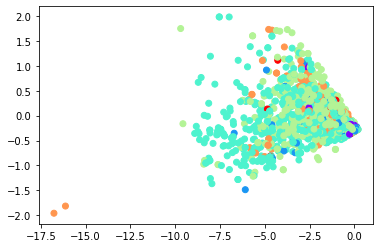

In [28]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = y,cmap = plt.cm.rainbow);

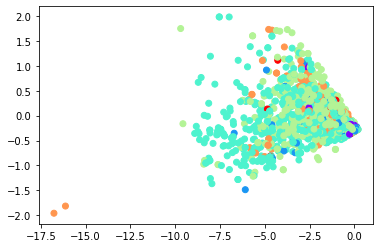

In [29]:
### with numpy
w, v = np.linalg.eig(np.cov(X, rowvar = 0))
ind = np.argsort(w)[::-1]
w, v = w[ind], v[:,ind]
X_pca = X @ v
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = y, cmap = plt.cm.rainbow);

### REMARKS

- numpyでの実行方法の方が直感的であると思われる